# Hello Kaggle!

Kaggle is a social media site for data scientists. Anyone in the world can signup and download datasets, then publish reports analysing said data. Kaggle also hosts world-class competitions for large cash prizes. These are generally hard to perform well in for the novice. Thus Kaggle has a **Getting Started** series for those just getting used to the platform, practicing programming, or enrolled in a machine learning course who want something challenging, yet digestable to start with. 

Analyzing house prices is a classic data science exercise. The goal is to relate features of a house (floor space, neighborhood, height of the basement ceiling, etc.) to its sold price. Zillow built a multi-billion dollar ad-business out of people gawking at home prices becuase they were very accurate. Thus predicting home prices with great precision is a valuable skill. Even though this particilar dataset is well studied, it offers useful lesssons for data analysis and regression statistics. I hope this notebook is useful for those getting started!

## Ames House Sales

The well cited [Boston housing dataset](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_boston.html) was orginally compiled by a Harvard economist in the 1970's (racism included). It was created to model the effects of air pollution on housing prices. In 2011 a Professor on sabattical wanted an updated dataset to use in his statistics course. Thus came the Ames, Iowa house sales dataset, containing 2,915 homes sold between 2006 and mid 2010. Each home is described by 79 features such as:
- characteristics (bedrooms, garage, fireplace, pool, porch, etc.)
- location (neighborhood)
- lot information (zoning, shape, size, etc.)
- ratings of condition and quality.
The features are a mix of nominal, ordinal, continuous, and discrete variables; a full spectrum of the data types seen in the real world.

Our goal is to predict each home's `SalePrice` from the other attributes. With so many possible combinations, it's best to start with a simple model which fits reasonably well, then experiment with more complicated interactions.


Reading the original [Ames paper](http://jse.amstat.org/v19n3/decock.pdf) provides a start. He recommends first create a simple model which scores about 80\% and then try a more complicated model.

# Importing and Cleaning Data

In [2]:
import pandas as pd
import numpy as np

from sklearn import linear_model
from sklearn import model_selection
from sklearn.preprocessing import PolynomialFeatures

import scipy

import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')
plt.style.use("homework")
import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn #ignore annoying warning (from sklearn and seaborn)

pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x)) #Limiting floats output to 3 decimal points

In [3]:
data = pd.read_csv("../input/house-prices-advanced-regression-techniques/train.csv")
print("Training data (observations, features):", data.shape)
data.set_index("Id", inplace=True)
data = data[data.GrLivArea < 4000]  # 5 outliers above 4000sqft
data["Area"] = data["TotalBsmtSF"] + data["GrLivArea"]
data["logSalePrice"] = np.log(data["SalePrice"])



test_data = pd.read_csv("../input/house-prices-advanced-regression-techniques/test.csv")
print("Test data (observations, features):", test_data.shape)  # missing column is SalePrice
print("Total Observations:", len(data)+len(test_data))
test_data["Area"] = test_data["TotalBsmtSF"] + test_data["GrLivArea"]
test_data["logSalePrice"] = np.log(data["SalePrice"])

test_data.set_index("Id", inplace=True)



Training data (observations, features): (1460, 81)
Test data (observations, features): (1459, 80)
Total Observations: 2915


In [4]:
dates = data[["YrSold", "MoSold"]]
dates["Set"] = "Train"
tdates = test_data[["YrSold", "MoSold"]]
tdates["Set"] = "Test"
dates = pd.concat([dates, tdates])
dates["date"] = pd.to_datetime(dates["YrSold"].astype(str) + "-" + dates["MoSold"].astype(str))
# dates.value_counts().sort_index().plot.bar()

In [5]:
import matplotlib.dates as mdates

Text(0.5, 1.0, 'Ames House Sales')

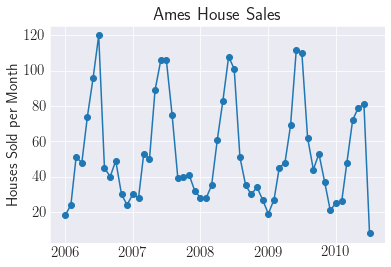

In [6]:
years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
years_fmt = mdates.DateFormatter('%Y') #This is a format. Will be clear in Screenshot

dtct = dates["date"].value_counts().sort_index()

fig, ax = plt.subplots()
ax.plot(dtct.index, dtct.values, "o-")
ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(years_fmt)
ax.xaxis.set_minor_locator(months)
ax.set_ylabel("Houses Sold per Month");
ax.set_title("Ames House Sales")
# plt.xticks(rotation = 'vertical');

## Location, Location, Location

Anyone could guess a bigger house would cost more. To check, first create the feature `Area` = `TotalBsmtSF` + `GrLivArea`. The scatterplot shows bigger homes do cost more, on average. Linear regression estimates a house costs about \$82 per sq.ft. How good is this model? A common measure is the root mean square error
$$
\text{RMSE} = \sqrt{\frac{1}{N} \sum_{i=1}^N (y_i - \hat y_i)^2} = \sqrt{\frac{1}{N} \| y - \hat y\|^2}
$$
where $y_i$ is each house's `SalePrice` and $\hat y_i = m x_i +b$ is the predicted house value given `Area` $x_i$. The notation $\|y - \hat y\|^2$ is called the *norm* of the residuals. This model's RMSE=43,763 meaning the prediction should be within \$40k, on average.

On average implies the data is normally distributed, without high values skewing away from the median. The scatterplot shows the data is not normal, with several houses priced very expensively. Taking the log of `SalePrice` transforms the scale to be more normal, and yields a log-space RMSE=.22. This transformed log-space will be the preferred measure from here on. A drawback of using log-space is the model coefficients and scores are not as easily interprettable.

Another common score is called the *coefficient of determination*
$$
R^2 = 1 - \frac{\|y - \hat y \|^2}{\| y - \textbf{avg}(y)\|^2}
$$
which ranges from a maximum of 1 when the model is perfect, 0 when $\hat y = \textbf{avg}(y)$, and can even be negative implying the model performs worse than guessing the average value. The denominator is the total variance of the target variable, and the numerator is the total squared error. An $R^2 > 0.80$ means the model accounts for about 80\% of the variance in the `SalePrice`. Using only `Area` the model yields $R^2=0.67$.

Just one more variable boosts $R^2$ to 0.80: adding `Neighborhood`. This is a categorical variable with 25 different neighborhoods. Visualzing `logSalePrice` ~ `Area` for each `Neighborhood` reveals much of the variance depends on location. Expressing the categories in a linear model is called one-hot-encoding. For each neighborhood, create a separate column with value 1 if the house is in that neighborhood and 0 otherwise. Now the data matrix $X$ has 25 columns. The second trick is to copy these 25 columns and multiply them by `Area`. In effect this is like splitting the dataset by each neighborhood and fitting a regression model as `logSalePrice` ~ `Area`. This boosts the RMSE from 0.228 to 0.166 and $R^2$ from 0.67 to 0.82. Simple and effective!

In [7]:
lm = linear_model.LinearRegression()
X = data["Area"].values.reshape(-1, 1)
y = data["logSalePrice"]
lm.fit(X, y)
print(lm.intercept_, lm.coef_)
yhat = lm.predict(X)
rmse = lambda y, yhat: np.sqrt(np.average(np.square(yhat - y)))

print(f"RMSE = {(rmse(y, yhat)):.3f}")
print(f"R^2={lm.score(X, y):.2f}")

10.933524715371323 [0.00042564]
RMSE = 0.228
R^2=0.67


In [8]:
# Neighborhood Model
X = pd.get_dummies(data["Neighborhood"])
Xa = X.mul(data["Area"], axis=0)
X = X.merge(Xa, left_index=True, right_index=True, suffixes=["", "_Area"])
lm = linear_model.LinearRegression(fit_intercept=False)
lm.fit(X, y)
yhat = lm.predict(X)
print(f"RMSE = {(rmse(y, yhat)):.3f}")
# print(lm.coef_)
lm.score(X, y)

RMSE = 0.166


0.8248624542019771

In [9]:
# All neighborhoods in Train and Test sets
neigh = data["Neighborhood"].unique()
neigh_test = test_data["Neighborhood"].unique()
neigh.sort() == neigh_test.sort()

True

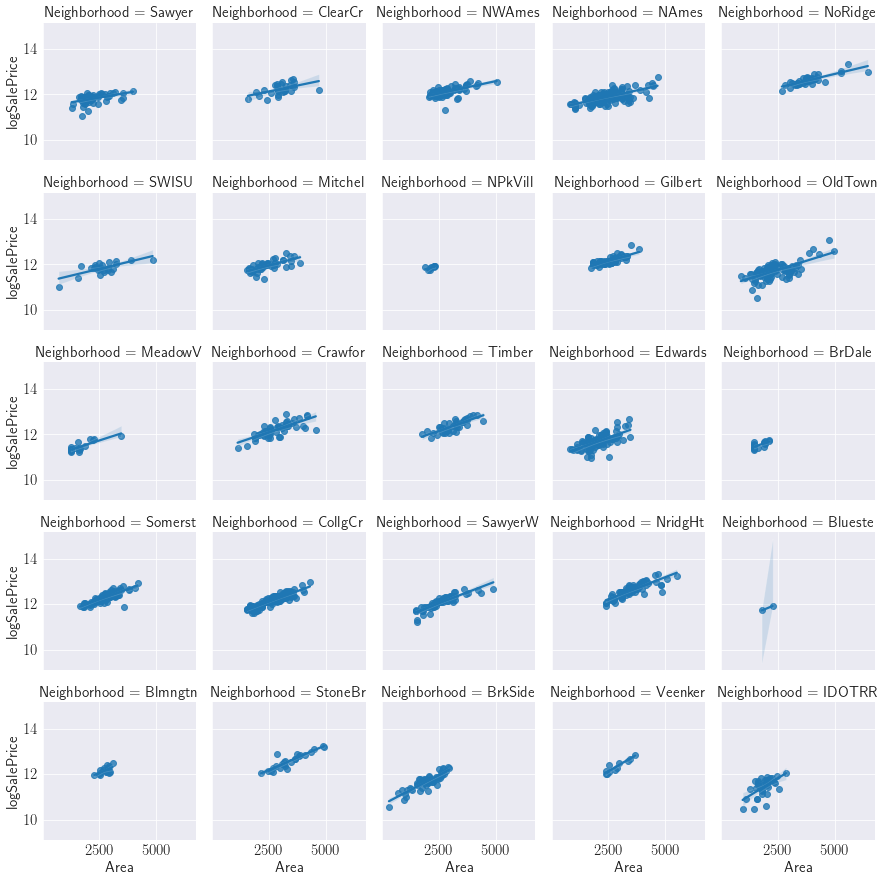

In [10]:
sns.lmplot(data=data, x="Area", y="logSalePrice", col="Neighborhood", 
        col_wrap=5, height=2.5, col_order=X.columns[:25][lm.coef_[25:].argsort()].values)

In [11]:
def currency(x, pos):
    """The two args are the value and tick position"""
    if abs(x) >= 1e6:
        if x < 0:
            s = '-\${:1.1f}M'.format(x*1e-6)
        else:
            s = '\${:1.1f}M'.format(x*1e-6)
    elif abs(x) > 1e3:
        if x < 0:
            s = '-\${:1.0f}K'.format(abs(x)*1e-3)
        else:
            s = '\${:1.0f}K'.format(x*1e-3)
    else:
        if x < 0:
            s = '-\${:f}'.format(abs(x))
        else:
            s = '\${:f}'.format(x)
    return s

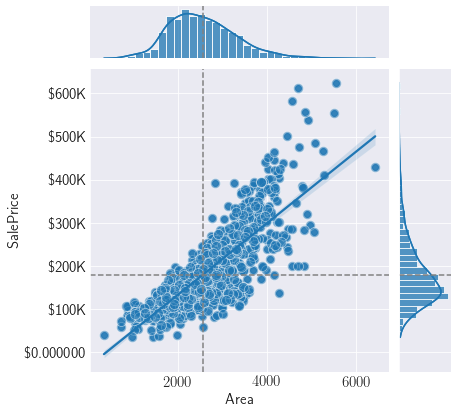

In [12]:
# Filtered out houses above 4000 sqft. 
# Solid correlation with a bunch of noise.
# Exercise: compare relationship by taking log10 of Area or SalePrice
h = sns.jointplot(data=data, x="Area", y="SalePrice", kind="reg")
h.plot_joint(sns.scatterplot, s=100, alpha=.5)
h.plot_marginals(sns.histplot, kde=True)
h.ax_joint.yaxis.set_major_formatter(currency)
# h.refline(x=data["Area"].median(), y=data["SalePrice"].median())
h.refline(x=data["Area"].mean(), y=data["SalePrice"].mean())

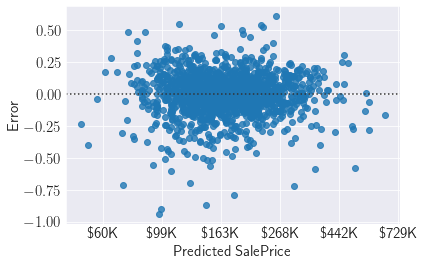

In [13]:
ax = sns.residplot(x=lm.predict(X), y=y)

ax.set_ylabel("Error")
ax.set_xlabel("Predicted SalePrice")
xticks = np.exp(ax.get_xticks())
xticks = [f"\${x/1000:.0f}K" for x in xticks]
yticks = np.exp(ax.get_yticks())
ax.set(
    xticklabels=xticks,
    # yticklabels=yticks
);

# ax.yaxis.set_major_formatter(currency);

## I'm high and need to relax.

In [15]:
data.columns

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'Wo

In [ ]:

nominal = ['MSSubClass', 'MSZoning', 'Street', 'Alley','LotShape', 
        'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
        'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
        'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd',
        'MasVnrType', 'Foundation', 'Heating', 'CentralAir',
        'Electrical', 'GarageType', 'PavedDrive', 'MiscFeature',
        'SaleType', 'SaleCondition'
    ] 
# All ordinal variables are best to worst
ordinal = ['OverallQual', 'OverallCond', 
        'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond',
        'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
        'HeatingQC', 'KitchenQual', 'Functional', 
        'FireplaceQu', 'GarageFinish', 'GarageQual', 'GarageCond',
        'PoolQC', 'Fence',
    ]
discrete = ['BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
        'BedroomAbvGr', 'KitchenAbvGr','TotRmsAbvGrd', 'Fireplaces',
        'YearBuilt', 'YearRemodAdd', 'GarageYrBlt', 'GarageCars',
    ]
continuous = ['LotFrontage', 'LotArea','MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 
        'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
        'GrLivArea', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
       'ScreenPorch', 'PoolArea', 'MiscVal',
    ]
datefeature = ['MoSold', 'YrSold']


In [81]:
def vis_price(described):
    N = described.shape[0]
    fig, axs = plt.subplots(2,1, tight_layout=True, figsize=(6,6))
    # error bars are absolute relative to the median
    axs[0].errorbar(x=np.arange(N), y=described["50%"], 
                yerr=np.abs(described[["25%", "75%"]].T.values - described["50%"].values), fmt='o', color="blue",
                ecolor='lightgray', elinewidth=2, capsize=0,
                label="Median Price")
    axs[0].scatter(np.arange(N), described["mean"], color="orange", label="Mean Price")
    axs[0].scatter(np.arange(N), described["min"], color="gray", alpha=0.5)
    axs[0].scatter(np.arange(N), described["max"], color="gray", alpha=0.5)

    axs[0].legend(loc="upper left")
    axs[0].set_ylim(bottom=0)
    axs[0].yaxis.set_major_formatter('${x:,.0f}')
    axs[0].xaxis.set_ticks([])

    axs[1].bar(np.arange(N), described["count"])
    for i in range(N):
        axs[1].text(i, described["count"][i], described["count"][i].astype(int),
            horizontalalignment='center',
            verticalalignment='bottom')
    axs[1].set_xticks(np.arange(N))
    axs[1].set_xticklabels(described.index.values, rotation=90)
    axs[1].set_xlabel(f"Group Ordered by Median House Price")
    axs[1].set_ylabel(f"Number of Houses in Group")
    return fig, axs

## Outliers in Expanded Model

The new model has 18 homes with residual values above \\$100k. There are 292 predictions within \\$5k. Let's compare how they are different.

`OverallQual` has a nonlinear trend to it. Fitting a degree-2 polynomial increases training $R^2 = 0.87$ (linear fit gives same $R^2=0.83$). Need to use Ridge Regression, otherwise solution has too much variance.

In [ ]:
outliers = data.loc[np.abs(resids) > 100000]
good_fit = data.loc[np.abs(resids) < 5000]
outliers["Fit"] = "Outlier"
good_fit["Fit"] = "Good"
goodout = pd.concat([outliers, good_fit])
goodout = goodout.merge(resids, left_index=True, right_index=True)

print("Number of outliers above $100k:", outliers.shape[0])
print("Number houses with residuals below $5k:", good_fit.shape[0])

ax = outliers.plot.scatter("Area", "SalePrice", color="orange", zorder=3)
good_fit.plot.scatter("Area", "SalePrice", color="green", alpha=0.5, ax=ax, zorder=2)
data.plot.scatter("Area", "SalePrice", alpha=0.1, ax=ax, zorder=1);

### Outlier Exploration

Feature     | Notes
-------     | -----
`MSSubClass`| outliers generally more expensive than normal
`MSZoning`  | outliers are only Low and Medium density residential, generally more expensive
`LotFrontage` | Outliers are above normal
`Condition1`| outliers are mostly in Normal group, only trend is they are more expensive.
`BldgType`  | outliers are single family homes with only 1 townhouse
`OverallQual` | Outliers are mostly good quality, but price varies widely within group. Adding Polyfit degree-2 improves $R^2$ by 0.04.
`OverallCond` | No trends with price. Outliers are mostly 5/10, with 3 a 9/10.
`YearBuilt` | Oldest house around 1880. Nonlinear trend with newer houses more pricy than older ones, except for the two outliers built before 1900. Adding regressor does not improve fit.
`YearRemodAdd` | Assuming houses with no remodeling have default value of 1950. Adding regressor does not significantly improve fit, but will keep it.
`MasVnrArea` | Has 8 NA's, fill with 0. Regressor slightly improves fit.
`ExterQual` | Outliers have Good and Excellent quality, trending towards higher range. Categories have large variation.
`BsmtFinSF1` | Some correlation visible. Regressor improves score about 0.01.

After brute force checking correlations, I realized using actual correlations might be a quicker method. Using this method I added 8 more feautures which improved $R^2$ from 0.89 to 0.90.

In [ ]:
P = goodout.corr()["Residuals"].drop(["Residuals", "SalePrice"])
P = P[np.abs(P) > .1].sort_values(ascending=False)
P

In [ ]:
sns.stripplot(data=goodout, x="SaleCondition", y="Residuals", hue="Fit")

In [ ]:
sns.lmplot(data=goodout, x="PoolArea", y="Residuals", order=1)

In [ ]:
pf = PolynomialFeatures()
qual = pf.fit_transform(data["OverallQual"].values.reshape(-1,1))
qual = pd.DataFrame(qual[:,1:], index=data["OverallQual"].index, columns=["OverallQual", "OverallQuall_2"], dtype=int)

Xint2 = Xint.copy()
Xint2 = Xint2.merge(qual, left_index=True, right_index=True)
Xint2["YearRemodAdd"] = data["YearRemodAdd"]
Xint2["MasVnrArea"] = data["MasVnrArea"].fillna(0)
Xint2["BsmtFinSF1"] = data["BsmtFinSF1"]  # R^2 = 0.889
Xint2["TotRmsAbvGrd"] = data["TotRmsAbvGrd"]
Xint2["2ndFlrSF"] = data["2ndFlrSF"]
Xint2["LowQualFinSF"] = data["LowQualFinSF"]
Xint2["OpenPorchSF"] = data["OpenPorchSF"]
Xint2["ScreenPorch"] = data["ScreenPorch"]
Xint2["Fireplaces"] = data["Fireplaces"]
Xint2["WoodDeckSF"] = data["WoodDeckSF"]
Xint2["LotArea"] = data["LotArea"]  # R^2 = 0.905

In [ ]:
lm2 = linear_model.RidgeCV(fit_intercept=False)
lm2.fit(Xint2, y)
print("R^2 =", lm2.score(Xint2, y))
# print(lm2.coef_)
print(f"Num Features: {Xint2.shape[1]}")
print("5-fold CV scores:", model_selection.cross_val_score(lm2, Xint2, y))

In [ ]:
yhat = lm2.predict(Xint2)
resids = yhat - y
print(f"Residuals mean {resids.mean():.2f}, SE = {resids.std():.3f}")
k2, p = scipy.stats.normaltest(resids)
if p < 0.001:
    print(f"Residuals are not normally distributed. p={p:.3f}")
else:
    print(f"Residuals might be normally distributed. p={p:.3f}")

g = sns.jointplot(yhat, y, kind="resid", )
g.set_axis_labels('x', 'y', fontsize=16)
g.ax_joint.set_xlabel('SalePrice')
g.ax_joint.set_ylabel('Residuals');
g.ax_joint.xaxis.set_major_formatter('${x:,.0f}')

In conclusion, the linear model captures about 90% of the variation in `SalePrice`. The standard prediction error is $23k. Residuals are not normally distributed, but they look bell-shaped. Trying to make money with this would be a risky proposition. But good enough for my first Kaggle submission!

# Test Predictions

In [ ]:
cols = ['YearRemodAdd',
       'MasVnrArea', 'BsmtFinSF1', 'TotRmsAbvGrd', '2ndFlrSF', 'LowQualFinSF',
       'OpenPorchSF', 'ScreenPorch', 'Fireplaces', 'WoodDeckSF', 'LotArea']

test_data["TotalBsmtSF"] = test_data["TotalBsmtSF"].fillna(0)
area = test_data["GrLivArea"] + test_data["TotalBsmtSF"]

X_test = pd.get_dummies(test_data["Neighborhood"])
X_test = X_test.merge(X_test.mul(area, axis=0).add_suffix("_Area"), 
            left_index=True, right_index=True)

pf = PolynomialFeatures()
qual = pf.fit_transform(test_data["OverallQual"].values.reshape(-1,1))
qual = pd.DataFrame(qual[:,1:], index=test_data["OverallQual"].index, columns=["OverallQual", "OverallQuall_2"], dtype=int)
X_test = X_test.merge(qual, left_index=True, right_index=True)
X_test = X_test.merge(test_data.loc[:, cols], left_index=True, right_index=True)
X_test["MasVnrArea"] = X_test["MasVnrArea"].fillna(0)
X_test["BsmtFinSF1"] = X_test["BsmtFinSF1"].fillna(0)

test_predictions = pd.Series(lm2.predict(X_test), index=X_test.index)  # error, some na
test_predictions.name = "SalePrice"
test_predictions.to_csv("submission.csv")